# Import des librairies nécessaires 

In [42]:
import pandas as pd
import json
import numpy as np
import os
import sys
import argparse
import dotenv 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from sklearn.model_selection import train_test_split

dotenv.load_dotenv()

True

# Chargement des données

In [ ]:
# Chargement des données écrites par l'humain
human_lines_path = 'data/en_human_lines.jsonl'
human_df = pd.read_json(human_lines_path, lines=True)
print("Le nombre de textes écrits par l'humaine est  : ", human_df.shape[0])

Le nombre de textes écrits par l'humaine est  :  6000


In [ ]:
# Chargement des données générées par le modèle GPT-2
gpt2_lines_path = 'data/en_gpt2_lines.jsonl'
gpt2_df = pd.read_json(gpt2_lines_path, lines=True)
print("Le nombre de textes générés par le modèle GPT-2 est  : ", gpt2_df.shape[0])

Le nombre de textes générés par le modèle GPT-2 est  :  6000


In [ ]:
# Chargement des données générées par le modèle GPT-3
gpt3_lines_path = 'data/en_gpt3_lines.jsonl'
gpt3_df = pd.read_json(gpt3_lines_path, lines=True)
print("Le nombre de textes générés par le modèle GPT-3 est  : ", gpt3_df.shape[0])

In [33]:
# Chargement des données générées par le modèle LLaMA
llama_lines_path = 'data/en_llama_lines.jsonl'
llama_df = pd.read_json(llama_lines_path, lines=True)
print("Le nombre de textes générés par le modèle LLaMA est  : ", llama_df.shape[0])

Le nombre de textes générés par le modèle LLaMA est  :  5904


# Prétraitement des données

## Création de la base de données

In [36]:
# Tirage aléatoire de 2000 textes dans chaque dataframe issu des LLMs
gpt2_sample = gpt2_df.sample(n=2000, random_state=42)
gpt3_sample = gpt3_df.sample(n=2000, random_state=42)
llama_sample = llama_df.sample(n=2000, random_state=42)

# Concaténation des échantillons dans un seul dataframe
sample_df = pd.concat([gpt2_sample, gpt3_sample, llama_sample], ignore_index=True)

# Ajout de toutes les données écrites par l'humain
sample_df = pd.concat([sample_df, human_df], ignore_index=True)

# Mélanger les lignes du dataframe
sample_df = sample_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Ajout du nombre de caractères dans chaque texte
sample_df['text_length'] = sample_df['text'].apply(len)

# Sauvegarde du dataframe échantillonné dans un fichier JSONL
sample_df.to_json('data/en_sample_lines.jsonl', orient='records', lines=True)

# Affichage du nombre total de textes   
print("Le nombre total de textes est : ", sample_df.shape[0])
# Affichage du nombre de textes par source
print("Le nombre de textes par source est :")
print(sample_df['label'].value_counts())

# Affichage du début du dataframe
print("Aperçu du dataframe échantillonné :")
print(sample_df.head())

Le nombre total de textes est :  12000
Le nombre de textes par source est :
label
human     6000
gpt2      2000
llama     2000
gpt3re    2000
Name: count, dtype: int64
Aperçu du dataframe échantillonné :
                                                text  prompt_len  label  \
0  In the triplet form, O 2 molecules are paramag...       298.0   gpt2   
1  Studies on income inequality and growth have s...         NaN  human   
2  JCF Capital ULC announced on Tuesday a deal wi...       226.0   gpt2   
3  The right to create private schools in Germany...         NaN  human   
4  during the week of 2015-05-11 Aatrox was last ...       790.0   gpt2   

   text_length  
0         1477  
1          605  
2          424  
3          622  
4         1361  


## Découpe de la base de données en base d'entraînement et base de test

In [39]:
# Découpe de la base de données en base d'entraînement et de test (80% - 20%)
train_df, test_df = train_test_split(sample_df, test_size=0.2, random_state=42)
# Sauvegarde des dataframes d'entraînement et de test dans des fichiers JSONL
train_df.to_json('data/en_train_lines.jsonl', orient='records', lines=True)
test_df.to_json('data/en_test_lines.jsonl', orient='records', lines=True)

In [44]:
sample_df.head()

,text,prompt_len,label,text_length
0,"In the triplet form, O 2 molecules are paramag...",298.0,gpt2,1477
1,Studies on income inequality and growth have s...,NaN,human,605
2,JCF Capital ULC announced on Tuesday a deal wi...,226.0,gpt2,424
3,The right to create private schools in Germany...,NaN,human,622
4,during the week of 2015-05-11 Aatrox was last ...,790.0,gpt2,1361


# Analyse descriptive

## Analyse élémentaire

In [40]:
# Affichage du nombre de textes dans les dataframes d'entraînement et de test
print("Le nombre de textes dans le dataframe d'entraînement est : ", train_df.shape[0])
print("Le nombre de textes dans le dataframe de test est : ", test_df.shape[0])

# Affichage du nombre de textes par source dans les dataframes d'entraînement et de test
print("Le nombre de textes par source dans le dataframe d'entraînement est :")
print(train_df['label'].value_counts())
print("Le nombre de textes par source dans le dataframe de test est :")
print(test_df['label'].value_counts())


Le nombre de textes dans le dataframe d'entraînement est :  9600
Le nombre de textes dans le dataframe de test est :  2400
Le nombre de textes par source dans le dataframe d'entraînement est :
label
human     4790
gpt3re    1614
llama     1601
gpt2      1595
Name: count, dtype: int64
Le nombre de textes par source dans le dataframe de test est :
label
human     1210
gpt2       405
llama      399
gpt3re     386
Name: count, dtype: int64


C:\Users\hp\AppData\Local\Temp\ipykernel_7652\749251633.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Source', fontsize=12)


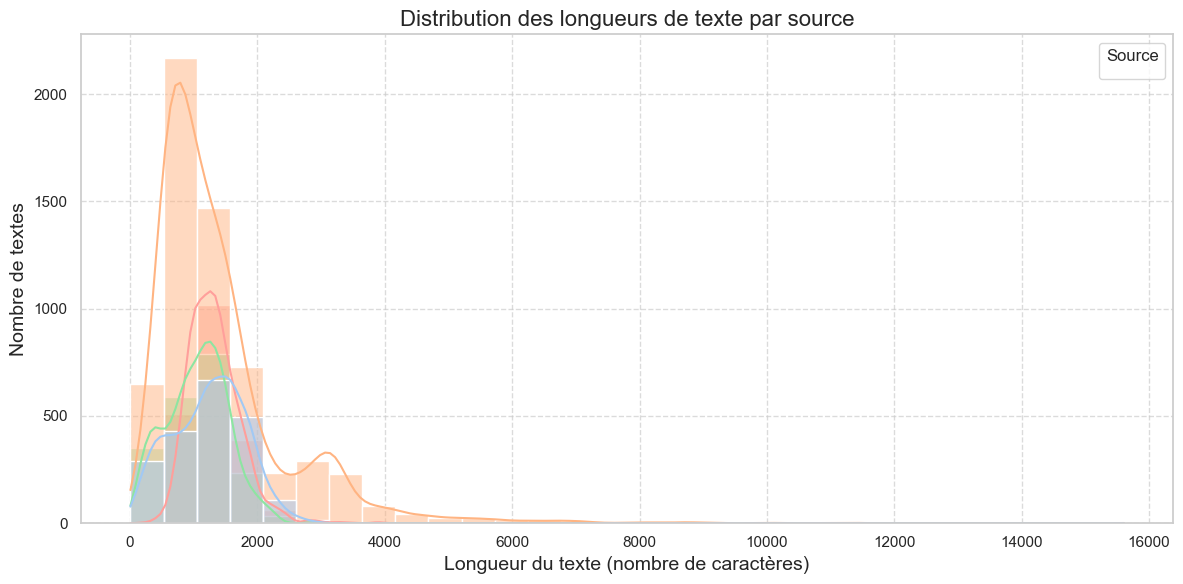

In [45]:
# Graphique de la distribution des longueurs de texte par source

# Configuration de Seaborn
sns.set(style="whitegrid")
sns.set_palette("pastel")

# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(12, 6))
# Création de l'histogramme
sns.histplot(data=sample_df, x='text_length', hue='label', bins=30, kde=True, ax=ax)
# Configuration des axes
ax.set_xlabel('Longueur du texte (nombre de caractères)', fontsize=14)
ax.set_ylabel('Nombre de textes', fontsize=14)
ax.set_title('Distribution des longueurs de texte par source', fontsize=16)
ax.legend(title='Source', fontsize=12)
# Affichage de la grille
ax.grid(True, linestyle='--', alpha=0.7)
# Affichage du graphique
plt.tight_layout()
# plt.savefig('data/text_length_distribution.png', dpi=300)
plt.show()

In [46]:
# Graphique du nombre de tokens par texte

In [ ]:
# Nuage de mots pour les textes écrits par l'humain

# Nuage de mots pour les textes générés par les LLMs (tout modèle confondu)

# Nuage de mots pour les textes générés par le modèle GPT2

# Nuage de mots pour les texte générés par le modèle GPT3   

# Nuage de mots pour les texte générés par le modèle LLaMA

## Définition de caractéristiques des données

In [ ]:
# Encodage des textes avec Bag-of-word

# Encodage des textes avec TF-IDF

# Tokenisation des textes avec BERT

# Embedding des tokens avec Word2Vec (à entraîner sur la base de données d'entraînement)

# Encodage des textes avec BERT

# Embedding des textes avec Sentence-BERT

# Encodage des textes avec FastText


In [ ]:
# Caractéristiques issues de https://aclanthology.org/2022.coling-1.573.pdf
# stylistiques 
## quote frequency (QF) : fréquence des ", ', «, », etc.
## ponctuation frequency (PF)  : fréquence des ., ;, :, !, ?, etc.
## punctuation types (PT) : nombre de types de ponctuation différents
## exclamation frequency (EF) : fréquence des !
## Stopwords frequency (SWF) : fréquence des mots vides (stopwords) (en utilisant nltk)
## Camel-case frequency (CCF) : fréquence des mots commençant 


# Caractéristiques issues de https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10191322&casa_token=0V5w74hKS34AAAAA:feek9xbq9qc-9nCtHZ2PUWKCHl0Gz9qUuCj8o25HvCB2xcv5n35q9mZnyNMjAu0kd7LM2QqKDvHAvv4&tag=1

# Modélisation

## Classifier par caractéristiques

### Modèle MultinomialNB

### Définition, entraînement et évaluation du modèle : 

In [ ]:
# Train a Naive Bayes classifier
# create the MultinomialNB
clf = MultinomialNB()
# Train 
clf.fit(X_train_tf, y_train)
# Evaluate 
print("Score sur l'ensemble d'entraînement :", clf.score(X_train_tf, y_train))
print("Score sur l'ensemble de test :", clf.score(X_test_tf, y_test))
print("Score sur l'ensemble dev:", clf.score(X_dev_tf, y_dev))

#### Analyse des erreurs 

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

y_pred = clf.predict(X_test_tf)
print(classification_report(y_test, y_pred))

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Affichage de la matrice de confusion
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=articles_df.category.unique())
disp.plot()

### Autres modèles

## LLM detector

### Définition du modèle

### Test - calcul des performances